In [2]:
import numpy as np

In [3]:
img_path = "/home/robertgshaw/imgs_np.npy"
data_raw = np.load(img_path)

In [6]:
from benchmark_pytorch import preprocess, postprocess
import torchvision.transforms as transforms
import torch

In [7]:
img_sz = 1280

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_sz, img_sz)),
    transforms.ConvertImageDtype(torch.float)
])

In [8]:
device = "cuda"

In [9]:
model = torch.hub.load("ultralytics/yolov5", "yolov5x6")
model.to(device)

Using cache found in /home/robertgshaw/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-4-20 Python-3.8.10 torch-2.0.1+cu117 CUDA:0 (Tesla T4, 14960MiB)



requirements: /home/robertgshaw/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5x6 summary: 574 layers, 140730220 parameters, 0 gradients
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 80, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(80, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(160, 80, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(160, 80, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(160, 160, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(80, 80, kernel_size=(1, 1), stride=(1, 1

In [21]:
if data_raw.shape[1:3] != (img_sz,img_sz):
    original_shape = data_raw.shape[1:3]
data = list(data_raw)

batch_size = 16
def get_batches(items):
    for i in range(0, len(items), batch_size):
        yield items[i:i+batch_size]

In [22]:
from concurrent.futures import ThreadPoolExecutor
executor = ThreadPoolExecutor(max_workers=8)

In [33]:
import time 

with torch.no_grad():
    model.eval()
    start = time.perf_counter()
    i = 0
    for batch in get_batches(data):
        print(f"{i} / {len(data) // batch_size}")
        model_inputs = preprocess(batch, executor, transform)
        model_outputs = model(model_inputs)
        outputs = postprocess(model_outputs, original_image_shape=original_shape, img_sz=img_sz)
        i += 1
    torch.cuda.synchronize()
    end = time.perf_counter()

throughput = len(data) / (end-start)
print(f"Pipeline Throughput: {round(throughput,2)}")

0 / 32
1 / 32
2 / 32
3 / 32
4 / 32
5 / 32
6 / 32
7 / 32
8 / 32
9 / 32
10 / 32
11 / 32
12 / 32
13 / 32
14 / 32
15 / 32
16 / 32
17 / 32
18 / 32
19 / 32
20 / 32
21 / 32
22 / 32
23 / 32
24 / 32
25 / 32
26 / 32
27 / 32
28 / 32
29 / 32
30 / 32
31 / 32
Pipeline Throughput: 4.57


In [26]:
%matplotlib inline

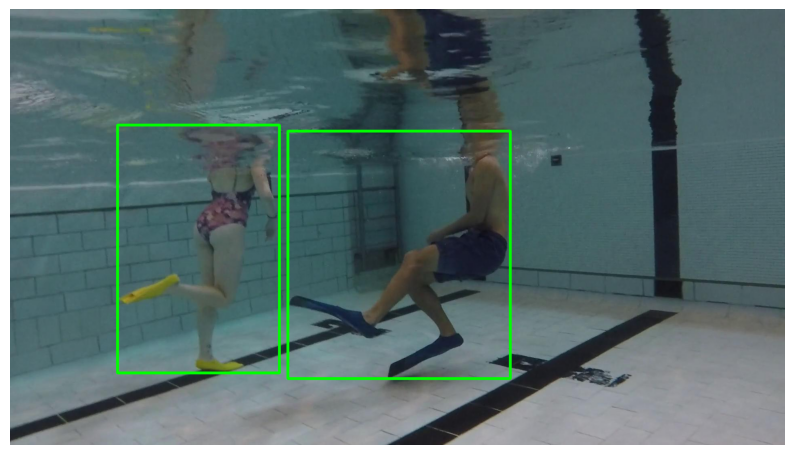

In [32]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(10, 10), facecolor='white')
index = 6
im = batch[index]

for xmin, ymin, xmax, ymax in outputs[0][index]:
    start_point = (int(xmin), int(ymin))
    end_point = (int(xmax), int(ymax))
    color = (0, 255, 0)
    thickness = 5
    im = cv2.rectangle(im, start_point, end_point, color, thickness)

plt.axis("off")
plt.imshow(im)